Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [41]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
import pandas as pd
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [42]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [314]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [315]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [307]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  """
  args:
    batch_size: the size of the batch to generate. The returned will be of size batch_size
    num_skips: the number of times a word is to be made predictions from
    skip_window: the number of words on each side of a target word that can be predicted
  returns:
    batch: the words from which predictions are to be made (center of window)
    labels: the predicted context words
  """
  
  # data_index is a global variable that represents the position of the buffer in the text
  global data_index
  
  # Each member of the batch should be trained for equally and thus should have an equal number of words drawn from the context
  assert batch_size % num_skips == 0
  
  # The skip window must be at least twice the number of skips in order to be large enough
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

  # The span is the size of the word list that the input word and context samples will be drawn from
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  
  # buffer is created to hold span elements. It is like a window and restricted to span words. When a new word is added, the oldest must be removed from buffer
  buffer = collections.deque(maxlen=span)
  
  # Add words in the span to the buffer
  for _ in range(span):
    buffer.append(data[data_index])
    # Increment the position (data_index). It is to return to 0 if it exceeds the length of the text
    data_index = (data_index + 1) % len(data)
  
  for i in range(batch_size // num_skips):
    # The word at the center of the window (buffer) is selected out
    target = skip_window

    # The context words selected must be unique and not the target so a list of words to avoid is created
    targets_to_avoid = [ skip_window ]
    
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'term', 'a', 'anarchism', 'originated', 'as', 'term', 'of']


Train a skip-gram model. The code was tested with sampled softmax and with Noise Contrastive Estimation (NCE) as the latter was once posited as being fast (relatively speaking).

In [339]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
#   softmax_weights = tf.Variable(
#     tf.truncated_normal([vocabulary_size, embedding_size],
#                          stddev=1.0 / math.sqrt(embedding_size)))
#   softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

  nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
  nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Model.
  # Look up embedding vectors (in embeddings) of inputs (in train_dataset).
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
#   loss = tf.reduce_mean(
#     tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
#                                labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
  
  # NCE loss instead of sampled softmax loss
  loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_labels,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size))
  
  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
#  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings to evaluate how the model is performing.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [340]:
num_steps = 100001
import time

start = time.time()

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 10000 == 0:
      if step > 0:
        average_loss = average_loss / 10000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step == 100000:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

print('time (seconds):', time.time() - start)

Initialized
Average loss at step 0: 287.027740
Average loss at step 10000: 48.546491
Average loss at step 20000: 10.190083
Average loss at step 30000: 6.659295
Average loss at step 40000: 5.690077
Average loss at step 50000: 5.304800
Average loss at step 60000: 4.996303
Average loss at step 70000: 4.923430
Average loss at step 80000: 4.743503
Average loss at step 90000: 4.729327
Average loss at step 100000: 4.627169
Nearest to time: realizing, rabba, saito, ursus, causal, splitting, silos, mjw,
Nearest to were: are, was, have, had, be, been, those, adar,
Nearest to during: after, in, against, when, through, including, ursus, under,
Nearest to by: was, through, against, ursus, be, prophase, mico, for,
Nearest to for: ursus, rabba, in, of, powerbook, mjw, folks, cebus,
Nearest to have: had, has, are, were, be, provide, powerbook, causal,
Nearest to no: a, brest, gnostic, overrun, coding, monterey, ursus, mosaic,
Nearest to american: british, german, english, neighbourhoods, existentialis

# Experimental results
Sampled softmax:
`Average loss at step 0: 8.334097
Average loss at step 10000: 3.888310
Average loss at step 20000: 3.559354
Average loss at step 30000: 3.308163
Average loss at step 40000: 3.353783
Average loss at step 50000: 3.408844
Average loss at step 60000: 3.394231
Average loss at step 70000: 3.285750
Average loss at step 80000: 3.320918
Average loss at step 90000: 3.336134
Average loss at step 100000: 3.309505
Nearest to known: used, regarded, such, defined, possible, available, seen, understood,
Nearest to also: now, often, still, usually, which, sometimes, below, never,
Nearest to i: we, ii, you, sugars, they, constitutions, iii, addicted,
Nearest to who: often, which, she, typically, still, generally, never, they,
Nearest to one: two, three, seven, six, four, eight, five, fy,
Nearest to state: states, council, government, constitution, share, fsb, republic, city,
Nearest to eight: nine, seven, six, five, four, three, zero, two,
Nearest to would: could, will, should, can, must, might, may, did,
Nearest to not: still, never, usually, generally, now, often, they, tumultuous,
Nearest to new: different, separate, modern, ehr, ebbinghaus, disestablishment, cenozoic, subspace,
Nearest to that: which, what, however, monarchic, where, prot, thus, because,
Nearest to years: days, decades, months, weeks, year, minutes, times, hours,
Nearest to by: through, naps, expresses, lopes, chani, cavity, including, dsp,
Nearest to during: after, before, in, when, at, within, under, until,
Nearest to this: it, which, rejoiced, some, itself, another, any, there,
Nearest to they: we, you, there, she, he, these, it, i,
Time (seconds): 201.36914467811584`

Using nce_loss:
`Initialized
Average loss at step 0: 287.027740
Average loss at step 10000: 48.546491
Average loss at step 20000: 10.190083
Average loss at step 30000: 6.659295
Average loss at step 40000: 5.690077
Average loss at step 50000: 5.304800
Average loss at step 60000: 4.996303
Average loss at step 70000: 4.923430
Average loss at step 80000: 4.743503
Average loss at step 90000: 4.729327
Average loss at step 100000: 4.627169
Nearest to time: realizing, rabba, saito, ursus, causal, splitting, silos, mjw,
Nearest to were: are, was, have, had, be, been, those, adar,
Nearest to during: after, in, against, when, through, including, ursus, under,
Nearest to by: was, through, against, ursus, be, prophase, mico, for,
Nearest to for: ursus, rabba, in, of, powerbook, mjw, folks, cebus,
Nearest to have: had, has, are, were, be, provide, powerbook, causal,
Nearest to no: a, brest, gnostic, overrun, coding, monterey, ursus, mosaic,
Nearest to american: british, german, english, neighbourhoods, existentialism, french, kjv, cooperating,
Nearest to it: he, this, there, she, monterey, which, they, ramps,
Nearest to i: ii, we, nomenclature, powerbook, appeal, disagreement, adds, ursus,
Nearest to was: is, were, had, has, became, by, rabi, be,
Nearest to many: some, these, several, all, those, other, such, both,
Nearest to two: three, four, six, five, one, seven, eight, zero,
Nearest to called: receives, artistic, feelgood, used, expand, fiji, referred, msc,
Nearest to d: b, chuan, brin, e, archimedean, nernst, biker, driscoll,
Nearest to one: two, six, seven, four, five, three, eight, mico,
time (seconds): 152.15433144569397`

When using nce_loss, training was much faster, by about 24.4%. However, the trained model had slightly greater loss and the similar words were, in my opinion, somewhat less reasonable:

Sampled softmax model:
* Nearest to one: two, three, seven, six, four, eight, five, fy,

NCE loss model:
* Nearest to one: two, six, seven, four, five, three, eight, mico,

Thus, it is difficult to declare one loss function superior to the other, though in the case of NCE loss, a fixed learning rate and a "vanilla" gradient descent optimizer was used. For the purpose of learning about the concept of word2vec, the choice does not seem significant, though it is curious that the authors of this graph chose to switch to using sampled softmax as opposed to NCE.

In [341]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

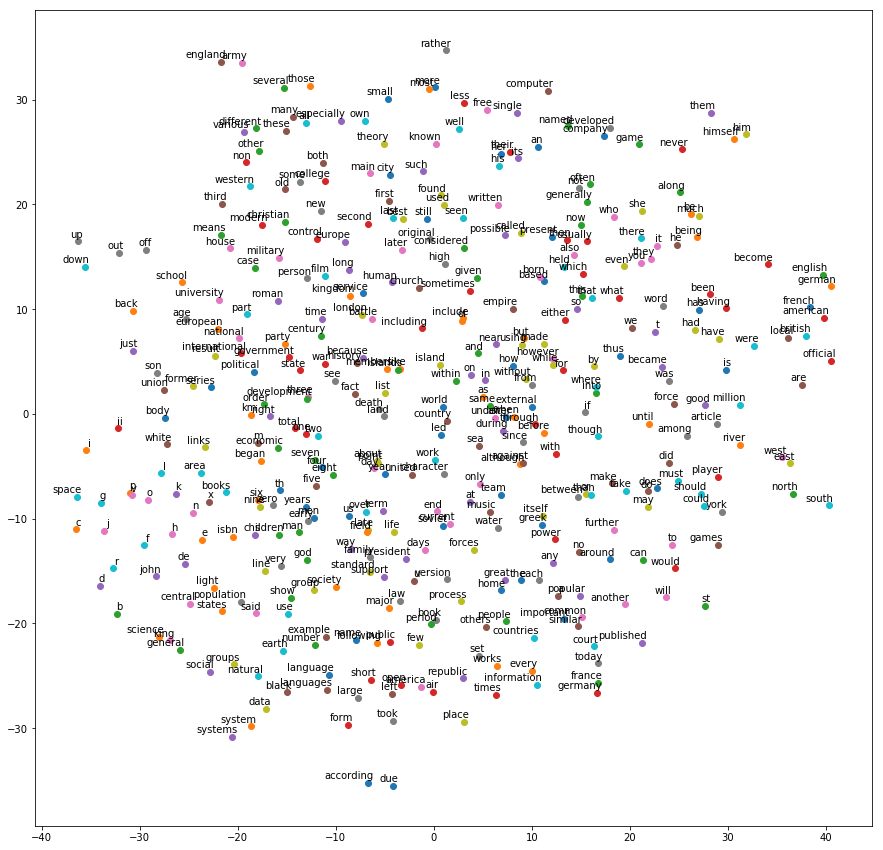

In [342]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

CBOW models require data in a different format. The CBOW architecture predicts a word based on its surrounding words whereas the skip gram architecture predicts surrounding words based on a given word. Thus, whereas the inputs to the skip gram model were of the form:
* Train_x: [center_word center_word ... center_word]
* Train_y: [context_word context_word ... context_word]

the inputs to the CBOW model should be of the form:
* Train_x: [context_word context_word ... context_word]
* Train_y: [center_word center_word ... center_word]

However, the term **skip** has no meaning in the context of the latter and the model architecture must consider all context words when predicting a single word, so the batch generation function must be altered accordingly.

In [343]:
data_index = 0

def generate_cbow_batch(batch_size, cbow_skip_window):
  """
  args:
    batch_size: the size of the batch to generate. The returned will be of size batch_size
    cbow_skip_window: the number of words to consider on a side of the word for predicting that word
  returns:
    batch: the words from which predictions are to be made (context words)
    labels: the predicted words (predicted from context)
  """
  global data_index
  batch = np.ndarray(shape=(batch_size, 2*cbow_skip_window), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  # Each window: [context_pt1 target context_pt2]
  window_size = 2 * cbow_skip_window + 1
  context_size = window_size - 1
  context = collections.deque(maxlen=window_size)
  
  for _ in range(window_size):
    context.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  for i in range(batch_size):
    target = cbow_skip_window + 1
    col = 0
    for word_num in range(window_size):
        if word_num != target:
            batch[i, col] = context[word_num]
            col += 1
    labels[i,0] = context[target]
    context.append(data[data_index])
    data_index = (data_index+1) % len(data)
  return batch, labels

batch, labels = generate_cbow_batch(8,2)
print('data:', [reverse_dictionary[di] for di in data[:8]])
print('\nbatch:')
for row in batch:
    print([reverse_dictionary[bi] for bi in row])
print('\nlabels:\n', [reverse_dictionary[li] for li in labels.reshape(8)])

batch_words = []
for row in batch:
    batch_words.append([reverse_dictionary[bi] for bi in row])
label_words = [reverse_dictionary[li] for li in labels.reshape(8)]

batch_words = pd.DataFrame(batch_words)
label_words = pd.DataFrame(label_words)
batch_df = pd.concat([label_words, batch_words], axis = 1)
batch_df.columns = ['labels', '', '', '', '']
batch_df

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

batch:
['anarchism', 'originated', 'as', 'term']
['originated', 'as', 'a', 'of']
['as', 'a', 'term', 'abuse']
['a', 'term', 'of', 'first']
['term', 'of', 'abuse', 'used']
['of', 'abuse', 'first', 'against']
['abuse', 'first', 'used', 'early']
['first', 'used', 'against', 'working']

labels:
 ['a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early']


,labels,,,,
0,a,anarchism,originated,as,term
1,term,originated,as,a,of
2,of,as,a,term,abuse
3,abuse,a,term,of,first
4,first,term,of,abuse,used
5,used,of,abuse,first,against
6,against,abuse,first,used,early
7,early,first,used,against,working


The computation graph must also be altered in light of the different format of the generated batches and in order for the model to consider context words as a single entity (i.e., by considering the average of the sum of the vectors of the surrounding words)

In [349]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
cbow_skip_window = 2 # How many words to consider left and right.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, cbow_skip_window*2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Take the average of the context embeddings
  embed = tf.div(tf.reduce_sum(embed, 1), cbow_skip_window*2)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [350]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_cbow_batch(
      batch_size, cbow_skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 10000 == 0:
      if step > 0:
        average_loss = average_loss / 10000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step == 100000:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.462256
Average loss at step 10000: 3.672903
Average loss at step 20000: 3.350116
Average loss at step 30000: 3.223366
Average loss at step 40000: 3.126443
Average loss at step 50000: 3.092598
Average loss at step 60000: 3.062803
Average loss at step 70000: 2.879668
Average loss at step 80000: 2.971481
Average loss at step 90000: 2.903488
Average loss at step 100000: 2.956059
Nearest to three: four, five, two, six, seven, eight, twenty, thirty,
Nearest to been: become, being, be, come, decoders, coprime, allston, was,
Nearest to from: through, back, beans, una, into, minstrels, ash, lexicographer,
Nearest to at: near, highland, refine, kaddish, keralite, corinthians, bronfman, discriminating,
Nearest to there: exiles, fortresses, unpredictability, implicit, outfitted, metabolised, eliezer, helaman,
Nearest to was: is, became, were, being, had, be, becomes, ambrosius,
Nearest to were: are, was, have, being, had, be, re, themselves,
Nearest to america

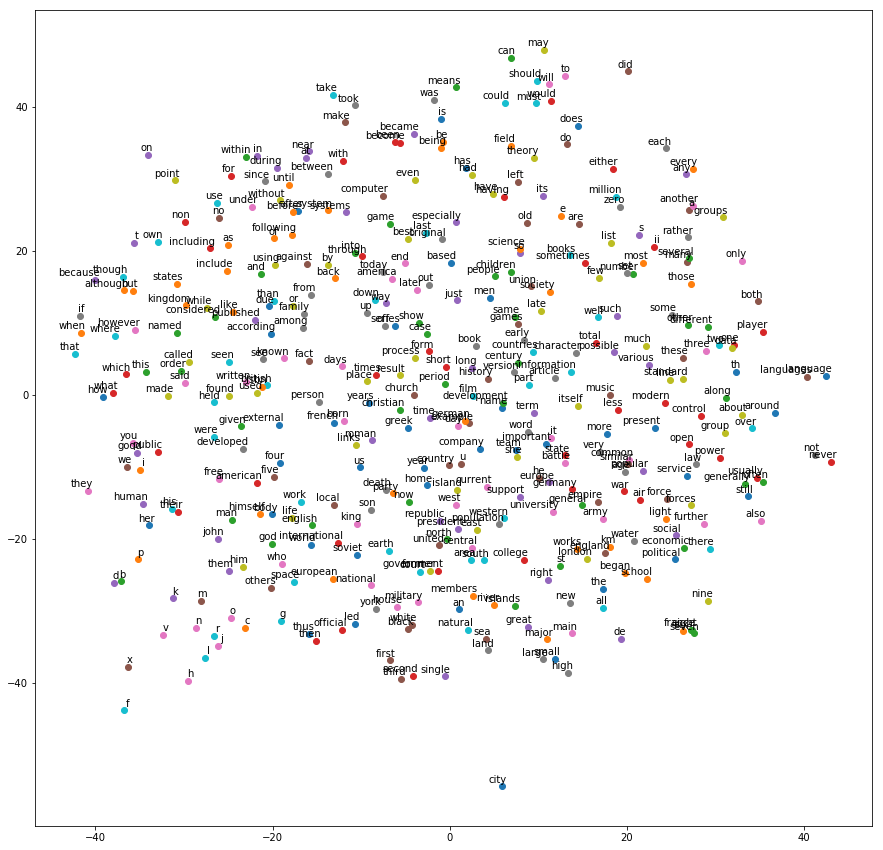

In [352]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

Performance on this CBOW model seems quite good when considering loss values relative to those of the skip gram model. Subjectively, nearest neighbors, for the most part, seem sensible:
* Nearest to three: four, five, two, six, seven, eight, twenty, thirty

Again, though, there are a few hiccups, most notably when it comes to relatively obscure words like **kaddish**:
* Nearest to at: near, highland, refine, **kaddish**, keralite, corinthians, bronfman, discriminating

These shortcomings may possibly be considered trivial in light of the small dataset and vocabulary size. Further, In terms of loss values, it seems to outperform the skip gram model. One may surmise that this design, CBOW, can work well. However, further investigation suggests that a larger dataset is needed. Consider the following nearest neighbors:
* Nearest to so: thus, miami, vauban, woolwich, burckhardt, lifetimes, disenfranchisement, ultimately,

It is difficult to make sense of most of the nearest neighbors. For the most part, proximiies in the above plot seem to be sensible, but the nearest neighbors of `so` suggest that this model has not been optimally trained. Perhaps such apparent shortcomings are permissible in certain scenarios, though. It seems that one must apply the particulars of one's scenario to reach a decision on which model is superior.